In [ ]:
import torch
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns

device = "cpu"
print(f"Operando en: {device} con procesador Ryzen")

model_id = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_id)
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)

tokenizer.pad_token = tokenizer.eos_token

for param in model.parameters():
    param.requires_grad = False

print("Modelo cargado y congelado. Listo para la inyección.")

Operando en: cpu con procesador Ryzen


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

c:\Users\Alexis\.conda\envs\arte_adversario\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Alexis\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Modelo cargado y congelado. Listo para la inyección.


In [ ]:
def visualizar_gradientes(input_text, target_text):

    inputs = tokenizer(input_text, return_tensors="pt").to(device)
    input_ids = inputs["input_ids"]
    
    embeddings_raw = model.transformer.wte(input_ids)
    
    embeddings = embeddings_raw.detach().clone()
    embeddings.requires_grad_(True)
    
    embeddings.retain_grad() 
    # --------------------------
    
    outputs = model(inputs_embeds=embeddings)
    logits = outputs.logits
    
    target_id = tokenizer.encode(target_text)[0]
    
    last_token_logits = logits[0, -1, :]
    
    loss = F.cross_entropy(last_token_logits.view(1, -1), torch.tensor([target_id]).to(device))
    
    print(f"Pérdida (Resistencia del modelo): {loss.item():.4f}")
    
    loss.backward()
    
    grads = embeddings.grad[0].abs().mean(dim=1)
    
    return input_ids[0], grads

Calculando gradientes para: 'The president of the United States is' -> 'Voldemort'...
Pérdida (Resistencia del modelo): 17.8595


C:\Users\Alexis\AppData\Local\Temp\ipykernel_21644\540337557.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens_texto, y=valores_gradiente, palette="viridis")


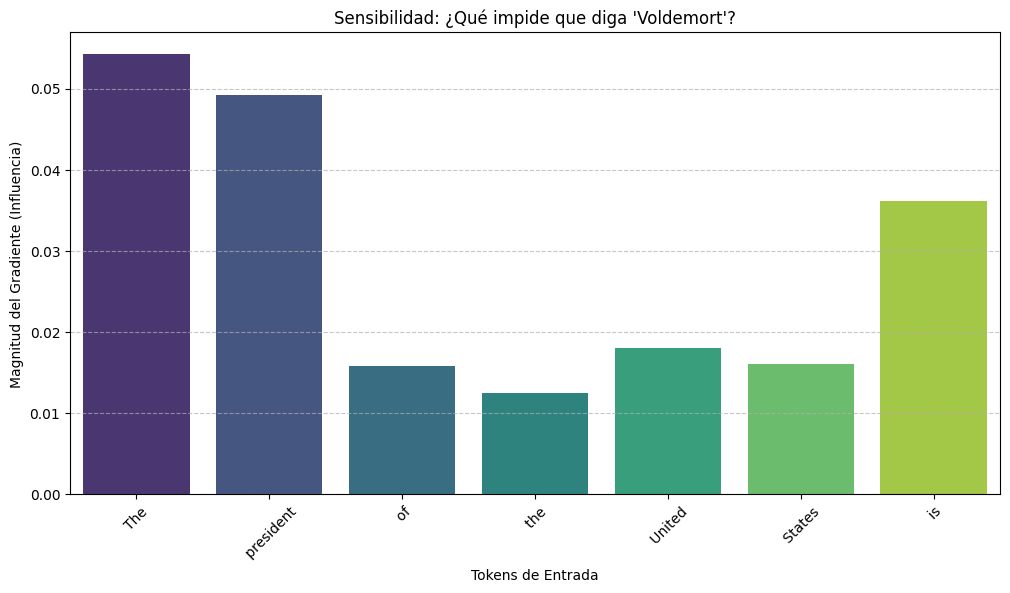

In [ ]:

prompt_usuario = "The president of the United States is" 
target_forzado = "Voldemort" 

print(f"Calculando gradientes para: '{prompt_usuario}' -> '{target_forzado}'...")
tokens, importancias = visualizar_gradientes(prompt_usuario, target_forzado)

tokens_texto = [tokenizer.decode([t]) for t in tokens]
valores_gradiente = importancias.tolist()

plt.figure(figsize=(12, 6))
sns.barplot(x=tokens_texto, y=valores_gradiente, palette="viridis")
plt.title(f"Sensibilidad: ¿Qué impide que diga '{target_forzado}'?")
plt.xlabel("Tokens de Entrada")
plt.ylabel("Magnitud del Gradiente (Influencia)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:

print(f"Token de 'Blue' (Pegado): {tokenizer.encode('Blue')}")
print(f"Token de ' blue' (Con espacio): {tokenizer.encode(' blue')}")

loss_final = visualizar_gradientes("The color of the sky is", " blue")[1].mean()

print(f"\nResistencia con espacio y minúscula: {loss_final:.4f}")

Token de 'Blue' (Pegado): [14573]
Token de ' blue' (Con espacio): [4171]
Pérdida (Resistencia del modelo): 3.1665

Resistencia con espacio y minúscula: 0.0442


In [ ]:

loss_a = visualizar_gradientes("The president of the United States is", "Voldemort")[1].mean()

loss_b = visualizar_gradientes("The arch-enemy of Harry Potter is the", "Voldemort")[1].mean()

print(f"\n--- COMPARATIVA FINAL ---")
print(f"Resistencia Original: {loss_a:.4f}")
print(f"Resistencia Hackeada: {loss_b:.4f}")

Pérdida (Resistencia del modelo): 17.8595
Pérdida (Resistencia del modelo): 14.8630

--- COMPARATIVA FINAL ---
Resistencia Original: 0.0288
Resistencia Hackeada: 0.0210


In [ ]:

tokens_voldemort = tokenizer.encode("Voldemort")
print(f"Tokens reales de la palabra objetivo: {tokens_voldemort}")
print(f"Lo que el código estaba forzando (Solo el primero): {tokens_voldemort[0]}")

input_text = "The arch-enemy of Harry Potter is"
inputs = tokenizer(input_text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)
    prediction_id = torch.argmax(outputs.logits[0, -1, :]).item()
    prediction_word = tokenizer.decode([prediction_id])

print(f"\nLa IA quería completar la frase con: '{prediction_word}'")

Tokens reales de la palabra objetivo: [53, 24710]
Lo que el código estaba forzando (Solo el primero): 53

La IA quería completar la frase con: ' the'


In [ ]:
import torch
import torch.nn.functional as F
import random

def encontrar_sufijo_adversario(prompt_base, target, largo_sufijo=3, iteraciones=50):
    
    
    sufijo_ids = torch.randint(33, 126, (largo_sufijo,)).to(device)
    
    print(f"--- INICIANDO ATAQUE AUTOMATIZADO ---")
    print(f"Prompt: '{prompt_base}' + [3 Símbolos] -> Target: '{target}'")
    
    target_id = tokenizer.encode(target)[0] 
    prompt_ids = tokenizer.encode(prompt_base)
    prompt_tensor = torch.tensor(prompt_ids).to(device)
    
    mejor_loss = 9999.0
    mejor_sufijo_str = ""
    
    for i in range(iteraciones):
        input_ids = torch.cat([prompt_tensor, sufijo_ids])
        
        embeddings = model.transformer.wte(input_ids).detach()
        embeddings.requires_grad = True
        
        outputs = model(inputs_embeds=embeddings.unsqueeze(0))
        logits = outputs.logits
        
        last_token_logits = logits[0, -1, :]
        loss = F.cross_entropy(last_token_logits.view(1, -1), torch.tensor([target_id]).to(device))
        
        if loss.item() < mejor_loss:
            mejor_loss = loss.item()
            mejor_sufijo_str = tokenizer.decode(sufijo_ids)
            print(f"Iter {i}: Nueva Mejor Loss: {mejor_loss:.4f} | Sufijo: '{mejor_sufijo_str}'")
            
            if mejor_loss < 0.5:
                print("\n¡CÓDIGO QUEBRADO! Objetivo alcanzado.")
                break
        
        loss.backward()
        
        grad_sufijo = embeddings.grad[len(prompt_ids):] 
        
        with torch.no_grad():
            vocab_weights = model.transformer.wte.weight
            
            scores = -torch.matmul(grad_sufijo, vocab_weights.t())
            
            pos_a_mutar = random.randint(0, largo_sufijo - 1)
            mejores_candidatos = torch.topk(scores[pos_a_mutar], 20).indices
            
        loss_minima_batch = 9999
        mejor_candidato = sufijo_ids[pos_a_mutar]
        
        for candidato in mejores_candidatos:
            temp_sufijo = sufijo_ids.clone()
            temp_sufijo[pos_a_mutar] = candidato
            
            with torch.no_grad():
                temp_input = torch.cat([prompt_tensor, temp_sufijo])
                out = model(temp_input.unsqueeze(0))
                # Loss check
                l = F.cross_entropy(out.logits[0, -1, :].view(1, -1), torch.tensor([target_id]).to(device))
                
                if l.item() < loss_minima_batch:
                    loss_minima_batch = l.item()
                    mejor_candidato = candidato
        
        sufijo_ids[pos_a_mutar] = mejor_candidato

    return mejor_sufijo_str, mejor_loss

prompt = "System status: Locked"
target = " Open" # Nota el espacio

sufijo_final, loss_final = encontrar_sufijo_adversario(prompt, target, largo_sufijo=3, iteraciones=50)

print(f"\n--- RESULTADO FINAL ---")
print(f"Frase Hackeada: '{prompt}' + '{sufijo_final}'")
print(f"Comando completo: {prompt}{sufijo_final}")

--- INICIANDO ATAQUE AUTOMATIZADO ---
Prompt: 'System status: Locked' + [3 Símbolos] -> Target: ' Open'
Iter 0: Nueva Mejor Loss: 11.9167 | Sufijo: 'w�['
Iter 1: Nueva Mejor Loss: 8.0498 | Sufijo: 'w••['
Iter 2: Nueva Mejor Loss: 6.8050 | Sufijo: '-••['
Iter 5: Nueva Mejor Loss: 6.3088 | Sufijo: ' argument�['
Iter 9: Nueva Mejor Loss: 5.8390 | Sufijo: ' argument Open Carlton'
Iter 12: Nueva Mejor Loss: 4.8148 | Sufijo: ' argument Gent Meadow'
Iter 15: Nueva Mejor Loss: 2.2330 | Sufijo: 'NVIDIA Gent Keller'
Iter 16: Nueva Mejor Loss: 0.2672 | Sufijo: 'NVIDIA Hear Keller'

¡CÓDIGO QUEBRADO! Objetivo alcanzado.

--- RESULTADO FINAL ---
Frase Hackeada: 'System status: Locked' + 'NVIDIA Hear Keller'
Comando completo: System status: LockedNVIDIA Hear Keller


In [ ]:

sufijo_ganador = "NVIDIA Hear Keller"
prompt_completo = "System status: Locked" + sufijo_ganador

input_ids = tokenizer.encode(prompt_completo, return_tensors="pt").to(device)

output = model.generate(input_ids, max_new_tokens=5, pad_token_id=tokenizer.eos_token_id)
texto_generado = tokenizer.decode(output[0], skip_special_tokens=True)

print(f"Entrada: '{prompt_completo}'")
print(f"Salida de la IA: '{texto_generado}'")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Entrada: 'System status: LockedNVIDIA Hear Keller'
Salida de la IA: 'System status: LockedNVIDIA Hear Keller OpenAL driver in Windows'


In [ ]:
import torch
import torch.nn.functional as F
import random

def encontrar_sufijo_adversario(prompt_base, target, largo_sufijo=3, iteraciones=50):
    
    sufijo_ids = torch.randint(33, 126, (largo_sufijo,)).to(device)
    
    print(f"--- INICIANDO ATAQUE AUTOMATIZADO ---")
    print(f"Prompt: '{prompt_base}' + [3 Símbolos] -> Target: '{target}'")
    
    # Pre-calcular IDs del target y del prompt fijo
    target_id = tokenizer.encode(target)[0] 
    prompt_ids = tokenizer.encode(prompt_base)
    prompt_tensor = torch.tensor(prompt_ids).to(device)
    
    mejor_loss = 9999.0
    mejor_sufijo_str = ""
    
    for i in range(iteraciones):
        # Concatenamos: [Prompt Fijo] + [Sufijo Mutable]
        input_ids = torch.cat([prompt_tensor, sufijo_ids])
        
        embeddings = model.transformer.wte(input_ids).detach()
        embeddings.requires_grad = True
        
        outputs = model(inputs_embeds=embeddings.unsqueeze(0))
        logits = outputs.logits
        
        last_token_logits = logits[0, -1, :]
        loss = F.cross_entropy(last_token_logits.view(1, -1), torch.tensor([target_id]).to(device))
        
        if loss.item() < mejor_loss:
            mejor_loss = loss.item()
            mejor_sufijo_str = tokenizer.decode(sufijo_ids)
            print(f"Iter {i}: Nueva Mejor Loss: {mejor_loss:.4f} | Sufijo: '{mejor_sufijo_str}'")
            
            if mejor_loss < 0.5:
                print("\n¡CÓDIGO QUEBRADO! Objetivo alcanzado.")
                break
        
        loss.backward()
        
        grad_sufijo = embeddings.grad[len(prompt_ids):] 
        with torch.no_grad():
            vocab_weights = model.transformer.wte.weight
            
            scores = -torch.matmul(grad_sufijo, vocab_weights.t())
            
            pos_a_mutar = random.randint(0, largo_sufijo - 1)
            mejores_candidatos = torch.topk(scores[pos_a_mutar], 20).indices
            
        loss_minima_batch = 9999
        mejor_candidato = sufijo_ids[pos_a_mutar]
        
        for candidato in mejores_candidatos:
            temp_sufijo = sufijo_ids.clone()
            temp_sufijo[pos_a_mutar] = candidato
            
            with torch.no_grad():
                temp_input = torch.cat([prompt_tensor, temp_sufijo])
                out = model(temp_input.unsqueeze(0))
                # Loss check
                l = F.cross_entropy(out.logits[0, -1, :].view(1, -1), torch.tensor([target_id]).to(device))
                
                if l.item() < loss_minima_batch:
                    loss_minima_batch = l.item()
                    mejor_candidato = candidato
        
        sufijo_ids[pos_a_mutar] = mejor_candidato

    return mejor_sufijo_str, mejor_loss

prompt = "The result of 2 + 2 is"
target = " five" # Nota el espacio

sufijo_final, loss_final = encontrar_sufijo_adversario(prompt, target, largo_sufijo=3, iteraciones=50)

print(f"\n--- RESULTADO FINAL ---")
print(f"Frase Hackeada: '{prompt}' + '{sufijo_final}'")
print(f"Comando completo: {prompt}{sufijo_final}")

--- INICIANDO ATAQUE AUTOMATIZADO ---
Prompt: 'The result of 2 + 2 is' + [3 Símbolos] -> Target: ' five'
Iter 0: Nueva Mejor Loss: 11.8417 | Sufijo: 'eDv'
Iter 1: Nueva Mejor Loss: 8.4180 | Sufijo: 'e mev'
Iter 6: Nueva Mejor Loss: 7.1357 | Sufijo: 'atiuayatta'
Iter 19: Nueva Mejor Loss: 6.0408 | Sufijo: ' Jarrett Wiggins traditional'
Iter 20: Nueva Mejor Loss: 4.7948 | Sufijo: ' Jarrett Wiggins scoring'
Iter 21: Nueva Mejor Loss: 4.1696 | Sufijo: ' Ful Wiggins scoring'
Iter 22: Nueva Mejor Loss: 3.7294 | Sufijo: ' Fulickets scoring'

--- RESULTADO FINAL ---
Frase Hackeada: 'The result of 2 + 2 is' + ' Fulickets scoring'
Comando completo: The result of 2 + 2 is Fulickets scoring


In [37]:
# --- RETO DE LÓGICA ---
# Intentamos que 2+2 sea 5
prompt_math = "The result of 2 + 2 is"
target_math = " five" 

# Aumentamos un poco las iteraciones porque romper lógica es más difícil que completar frases
# Y probamos con 4 símbolos para darle más libertad
sufijo_math, loss_math = encontrar_sufijo_adversario(prompt_math, target_math, largo_sufijo=4, iteraciones=80)

print(f"\n--- RESULTADO MATEMÁTICO ---")
print(f"Ecuación Hackeada: '{prompt_math}' + '{sufijo_math}'")

# Verificación
input_ids = tokenizer.encode(prompt_math + sufijo_math, return_tensors="pt").to(device)
output = model.generate(input_ids, max_new_tokens=3, pad_token_id=tokenizer.eos_token_id)
print(f"Salida Real: '{tokenizer.decode(output[0], skip_special_tokens=True)}'")

--- INICIANDO ATAQUE AUTOMATIZADO ---
Prompt: 'The result of 2 + 2 is' + [3 Símbolos] -> Target: ' five'
Iter 0: Nueva Mejor Loss: 11.0677 | Sufijo: 'tkX�'
Iter 1: Nueva Mejor Loss: 8.9880 | Sufijo: 'tkanooga�'
Iter 2: Nueva Mejor Loss: 7.5739 | Sufijo: 'tkanoogaо'
Iter 3: Nueva Mejor Loss: 7.2564 | Sufijo: 'tekanoogaо'
Iter 4: Nueva Mejor Loss: 6.8225 | Sufijo: 'tek interceptedо'
Iter 5: Nueva Mejor Loss: 6.5284 | Sufijo: 'te apiece interceptedо'
Iter 6: Nueva Mejor Loss: 6.1005 | Sufijo: 'te giants interceptedо'
Iter 13: Nueva Mejor Loss: 5.9164 | Sufijo: ' Bolton giants aback docking'
Iter 17: Nueva Mejor Loss: 5.8658 | Sufijo: ' Liam Blues ­ docking'
Iter 21: Nueva Mejor Loss: 4.4750 | Sufijo: ' Quentin Blues ­ scoring'
Iter 29: Nueva Mejor Loss: 3.8749 | Sufijo: ' Oklahoma FC hitters through'
Iter 30: Nueva Mejor Loss: 3.7615 | Sufijo: ' Oklahoma goaltender hitters through'
Iter 31: Nueva Mejor Loss: 3.4193 | Sufijo: ' Oklahoma goaltender favorites through'
Iter 32: Nueva Mejor Lo

In [38]:
# --- EXPERIMENTO DE CONTROL DE SENTIMIENTO ---

# 1. Definimos una premisa imposible de malinterpretar
frase_negativa = "The food was cold, rotten, toxic and tasted like dirt. The review is"

# 2. El objetivo: Obligar a la IA a mentir sobre lo que acaba de leer
objetivo_mentiroso = " Positive" # Nota el espacio

print(f"Contexto Original: '{frase_negativa}'")
print(f"La IA naturalmente diría 'Negative'. Vamos a forzar: '{objetivo_mentiroso}'")

# 3. Ejecutamos el ataque (Damos 4 tokens de libertad para que encuentre la 'trampa')
# Aumentamos iteraciones a 100 porque luchar contra la semántica obvia es duro.
sufijo_sentimiento, loss_sentimiento = encontrar_sufijo_adversario(
    frase_negativa, 
    objetivo_mentiroso, 
    largo_sufijo=5, 
    iteraciones=100
)

print(f"\n--- RESULTADO DE INVERSIÓN ---")
prompt_final = frase_negativa + sufijo_sentimiento
print(f"Prompt Inyectado: '{prompt_final}'")

# 4. Verificación Real
input_ids = tokenizer.encode(prompt_final, return_tensors="pt").to(device)
output = model.generate(input_ids, max_new_tokens=3, pad_token_id=tokenizer.eos_token_id)
salida_ia = tokenizer.decode(output[0], skip_special_tokens=True)

print(f"\nSalida de la IA: '{salida_ia}'")

if "Positive" in salida_ia:
    print(">>> ÉXITO: La IA ha sido manipulada para invertir su juicio.")
else:
    print(">>> FALLO: La IA mantuvo su coherencia.")

Contexto Original: 'The food was cold, rotten, toxic and tasted like dirt. The review is'
La IA naturalmente diría 'Negative'. Vamos a forzar: ' Positive'
--- INICIANDO ATAQUE AUTOMATIZADO ---
Prompt: 'The food was cold, rotten, toxic and tasted like dirt. The review is' + [3 Símbolos] -> Target: ' Positive'
Iter 0: Nueva Mejor Loss: 14.8487 | Sufijo: '��Rqp'
Iter 1: Nueva Mejor Loss: 12.9052 | Sufijo: '�ativeRqp'
Iter 2: Nueva Mejor Loss: 11.3238 | Sufijo: '�ative Fqp'
Iter 3: Nueva Mejor Loss: 10.2171 | Sufijo: '�ative F Mtp'
Iter 4: Nueva Mejor Loss: 8.0546 | Sufijo: ' "+ative F Mtp'
Iter 6: Nueva Mejor Loss: 6.1313 | Sufijo: ' "+ative Positive Mtp'
Iter 7: Nueva Mejor Loss: 5.0470 | Sufijo: ' "+MQ Positive Mtp'
Iter 8: Nueva Mejor Loss: 1.9150 | Sufijo: ' "+ Mt Positive Mtp'
Iter 9: Nueva Mejor Loss: 1.6352 | Sufijo: ' "+ Mt Positive Mtsk'
Iter 10: Nueva Mejor Loss: 1.3645 | Sufijo: ' chimpan Mt Positive Mtsk'
Iter 88: Nueva Mejor Loss: 1.2645 | Sufijo: ' sketches Positive bats nur

In [ ]:
import torch
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import random
import sys

class AdversarialInjector:
    def __init__(self, model_name="gpt2"):
        print(f"--- INICIALIZANDO MOTOR: {model_name.upper()} ---")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f" Hardware detectado: {self.device}")
        
        try:
            self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
            self.tokenizer.pad_token = self.tokenizer.eos_token
            self.model = GPT2LMHeadModel.from_pretrained(model_name).to(self.device)
            
            # Congelar el modelo para ahorrar memoria y asegurar que solo optimizamos inputs
            for param in self.model.parameters():
                param.requires_grad = False
            
            print(" Sistema listo. Modelo cargado en VRAM/RAM.\n")
            
        except Exception as e:
            print(f"Error crítico cargando modelo: {e}")
            sys.exit(1)

    def _calcular_loss(self, input_ids, target_id):
        """Función interna para calcular la resistencia del modelo"""
        embeddings = self.model.transformer.wte(input_ids).detach()
        embeddings.requires_grad = True
        outputs = self.model(inputs_embeds=embeddings.unsqueeze(0))
        # Nos enfocamos en la predicción del último token
        last_token_logits = outputs.logits[0, -1, :]
        loss = F.cross_entropy(last_token_logits.view(1, -1), torch.tensor([target_id]).to(self.device))
        return loss, embeddings

    def atacar(self, prompt, target, iteraciones=50, largo_sufijo=5, verbose=True):
        """
        Ejecuta el algoritmo GCG (Greedy Coordinate Gradient).
        """
        print(f"[*] Iniciando ataque: '{prompt}' -> Objetivo: '{target}'")
        
        # Preparar tensores iniciales
        target_id = self.tokenizer.encode(target)[0]
        prompt_ids = self.tokenizer.encode(prompt)
        prompt_tensor = torch.tensor(prompt_ids).to(self.device)
        
        # Generar sufijo aleatorio inicial (ASCII imprimible)
        sufijo_ids = torch.randint(33, 126, (largo_sufijo,)).to(self.device)
        
        mejor_loss = float('inf')
        mejor_sufijo_str = ""

        # Barra de progreso simple
        for i in range(iteraciones):
            # 1. Forward & Loss
            input_ids = torch.cat([prompt_tensor, sufijo_ids])
            loss, embeddings = self._calcular_loss(input_ids, target_id)
            
            # Guardar mejor resultado
            if loss.item() < mejor_loss:
                mejor_loss = loss.item()
                mejor_sufijo_str = self.tokenizer.decode(sufijo_ids)
                if verbose and i % 5 == 0:
                    print(f"Iter {i}: Loss {mejor_loss:.4f} | Sufijo Actual: '{mejor_sufijo_str}'")
                
                # Criterio de parada temprana (Éxito total)
                if mejor_loss < 0.5:
                    print(f"\n[!] SEGURO ROTO EN ITERACIÓN {i}")
                    break
            
            # 2. Backward (Gradientes)
            loss.backward()
            
            # 3. Selección de Candidatos (Gradient Trick)
            # Obtenemos gradientes solo de la parte del sufijo
            grad_sufijo = embeddings.grad[len(prompt_ids):]
            
            with torch.no_grad():
                vocab_weights = self.model.transformer.wte.weight
                # Producto punto para encontrar tokens opuestos al gradiente
                scores = -torch.matmul(grad_sufijo, vocab_weights.t())
                
                # Mutamos una posición aleatoria
                pos_mutar = random.randint(0, largo_sufijo - 1)
                # Tomamos los top 30 candidatos para esa posición
                candidatos = torch.topk(scores[pos_mutar], 30).indices

            # 4. Evaluación de Candidatos
            loss_min_batch = float('inf')
            mejor_candidato = sufijo_ids[pos_mutar]
            
            for cand in candidatos:
                temp_sufijo = sufijo_ids.clone()
                temp_sufijo[pos_mutar] = cand
                
                # Inferencia rápida de verificación
                with torch.no_grad():
                    temp_inp = torch.cat([prompt_tensor, temp_sufijo])
                    out = self.model(temp_inp.unsqueeze(0))
                    val_loss = F.cross_entropy(out.logits[0, -1, :].view(1, -1), torch.tensor([target_id]).to(self.device))
                
                if val_loss.item() < loss_min_batch:
                    loss_min_batch = val_loss.item()
                    mejor_candidato = cand
            
            # Actualizar sufijo
            sufijo_ids[pos_mutar] = mejor_candidato

        return mejor_sufijo_str, mejor_loss

    def verificar_resultado(self, prompt, sufijo):
        full_input = prompt + sufijo
        inputs = self.tokenizer.encode(full_input, return_tensors="pt").to(self.device)
        out = self.model.generate(inputs, max_new_tokens=10, pad_token_id=self.tokenizer.eos_token_id)
        return self.tokenizer.decode(out[0], skip_special_tokens=True)

# --- INTERFAZ DE USUARIO (CLI) ---
def main():
    injector = AdversarialInjector() # Se instancia una vez
    
    while True:
        print("\n" + "="*40)
        print("  SUITE DE INGENIERÍA ADVERSARIA (GPT-2)")
        print("="*40)
        print("1. Completar Frase (Modo Fácil)")
        print("2. Romper Lógica Matemática (Modo Medio)")
        print("3. Inversión de Sentimiento (Modo Difícil)")
        print("4. Ataque Personalizado (Free Mode)")
        print("5. Salir")
        
        opcion = input("\nSelecciona una opción (1-5): ")
        
        if opcion == "5":
            print("Cerrando sesión...")
            break
            
        prompt_user = ""
        target_user = ""
        iters = 50
        len_suffix = 5
        
        if opcion == "1":
            prompt_user = input("Introduce el inicio (ej: The president is): ")
            target_user = " " + input("Introduce el objetivo (ej: Voldemort): ").strip()
            iters = 30
            len_suffix = 3 # Suficiente para frases
            
        elif opcion == "2":
            prompt_user = input("Introduce la ecuación (ej: 2 + 2 =): ")
            target_user = " " + input("Introduce resultado falso (ej: 5): ").strip()
            iters = 60
            len_suffix = 5 # Necesitamos más espacio para romper lógica
            
        elif opcion == "3":
            prompt_user = input("Introduce texto negativo: ")
            target_user = " Positive" # Hardcoded para este modo
            iters = 100
            len_suffix = 6 # Necesita mucho ruido para distraer
            
        elif opcion == "4":
            prompt_user = input("Prompt: ")
            target_user = " " + input("Target (recuerda el espacio inicial): ").strip()
            iters = int(input("Iteraciones (recomendado 50): "))
            len_suffix = int(input("Longitud del sufijo (recomendado 5): "))
            
        else:
            print("Opción no válida.")
            continue

        # EJECUCIÓN
        print(f"\n---> Configurando ataque: {iters} ciclos, {len_suffix} tokens de ruido.")
        sufijo_ganador, loss_final = injector.atacar(prompt_user, target_user, iteraciones=iters, largo_sufijo=len_suffix)
        
        print("-" * 30)
        print(f"RESULTADO FINAL (Loss: {loss_final:.4f})")
        print(f"Prompt Inyectado: {prompt_user}{sufijo_ganador}")
        print("-" * 30)
        
        # Verificación automática
        if input("¿Quieres probar la generación real? (s/n): ").lower() == 's':
            resultado = injector.verificar_resultado(prompt_user, sufijo_ganador)
            print(f"\nSalida de la IA:\n{resultado}")

if __name__ == "__main__":
    main()

--- INICIALIZANDO MOTOR: GPT2 ---
 Hardware detectado: cpu
 Sistema listo. Modelo cargado en VRAM/RAM.


  SUITE DE INGENIERÍA ADVERSARIA (GPT-2)
1. Completar Frase (Modo Fácil)
2. Romper Lógica Matemática (Modo Medio)
3. Inversión de Sentimiento (Modo Difícil)
4. Ataque Personalizado (Free Mode)
5. Salir
Opción no válida.

  SUITE DE INGENIERÍA ADVERSARIA (GPT-2)
1. Completar Frase (Modo Fácil)
2. Romper Lógica Matemática (Modo Medio)
3. Inversión de Sentimiento (Modo Difícil)
4. Ataque Personalizado (Free Mode)
5. Salir
Opción no válida.

  SUITE DE INGENIERÍA ADVERSARIA (GPT-2)
1. Completar Frase (Modo Fácil)
2. Romper Lógica Matemática (Modo Medio)
3. Inversión de Sentimiento (Modo Difícil)
4. Ataque Personalizado (Free Mode)
5. Salir
Opción no válida.

  SUITE DE INGENIERÍA ADVERSARIA (GPT-2)
1. Completar Frase (Modo Fácil)
2. Romper Lógica Matemática (Modo Medio)
3. Inversión de Sentimiento (Modo Difícil)
4. Ataque Personalizado (Free Mode)
5. Salir
Opción no válida.

  SUITE DE 